In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.datasets import co2
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error, mean_squared_error
import statsmodels as sm
import warnings
warnings.filterwarnings("ignore")

##### **importing the Co2 dataset**

In [2]:
data = pd.DataFrame(sm.datasets.co2.load().data)

In [3]:
data

,co2
1958-03-29,316.1
1958-04-05,317.3
1958-04-12,317.6
1958-04-19,317.5
1958-04-26,316.4
...,...
2001-12-01,370.3
2001-12-08,370.8
2001-12-15,371.2
2001-12-22,371.3


##### **Converting the given data to a monthly time series data**

In [4]:
data = data.resample('M').mean()

In [5]:
data

,co2
1958-03-31,316.100000
1958-04-30,317.200000
1958-05-31,317.433333
1958-06-30,NaN
1958-07-31,315.625000
...,...
2001-08-31,369.425000
2001-09-30,367.880000
2001-10-31,368.050000
2001-11-30,369.375000


##### **checking the null values**

In [6]:
data.isnull().sum()

co2    5
dtype: int64

In [7]:
data.isnull()

,co2
1958-03-31,False
1958-04-30,False
1958-05-31,False
1958-06-30,True
1958-07-31,False
...,...
2001-08-31,False
2001-09-30,False
2001-10-31,False
2001-11-30,False


##### **doing the backward fill first**

In [8]:
data = data.bfill()

In [9]:
data.isnull().sum()

co2    0
dtype: int64

##### *treated the null values using the backward filling*

##### **Plots of monthly time series data**

In [10]:
import seaborn as sns 

##### **Scatter plot**

<Axes: >

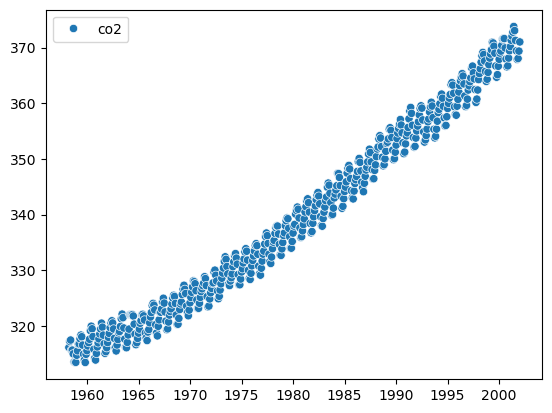

In [11]:
sns.scatterplot(data)

##### Graph shows that how the concentration of co2 increase from 1960 to 2000 usin the monthly time. 
##### as we see that 1960 it is very around the 320 and In 2000 it goes upto the 370 ppm.
##### which shows that there is significantly linear increase of emission of co2 from 1960 to 2000.

##### **line plot**

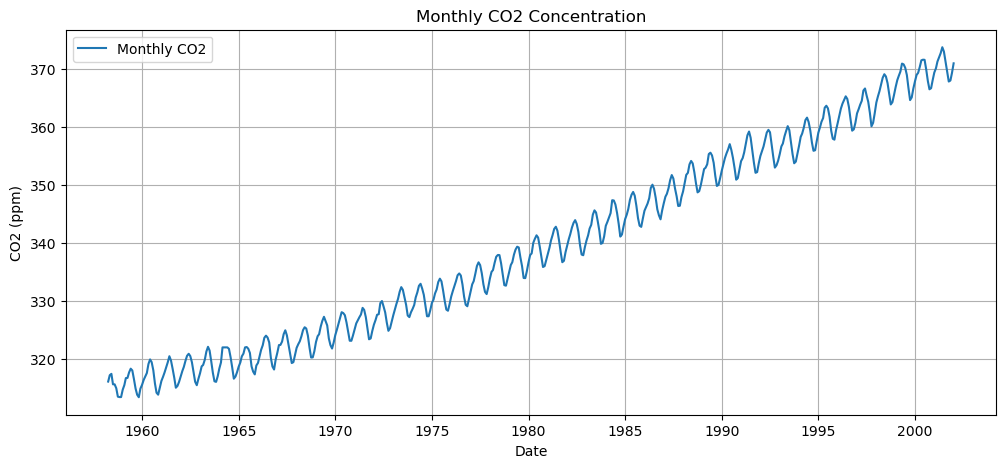

In [12]:
plt.figure(figsize=(12, 5))
plt.plot(data, label='Monthly CO2')
plt.title('Monthly CO2 Concentration')
plt.xlabel('Date')
plt.ylabel('CO2 (ppm)')
plt.legend()
plt.grid(True)
plt.show()

##### Showing the same data but using the line plot with more clearity

##### **bar plot**

<Axes: >

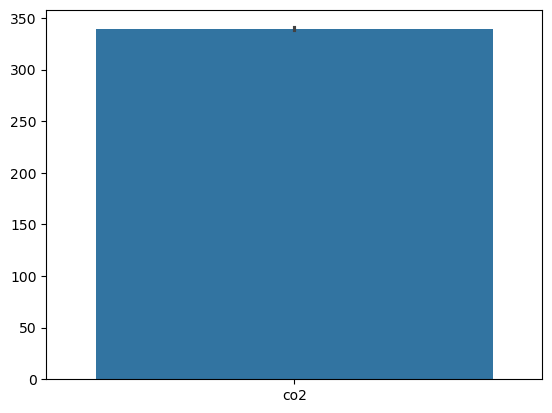

In [13]:
sns.barplot(data)

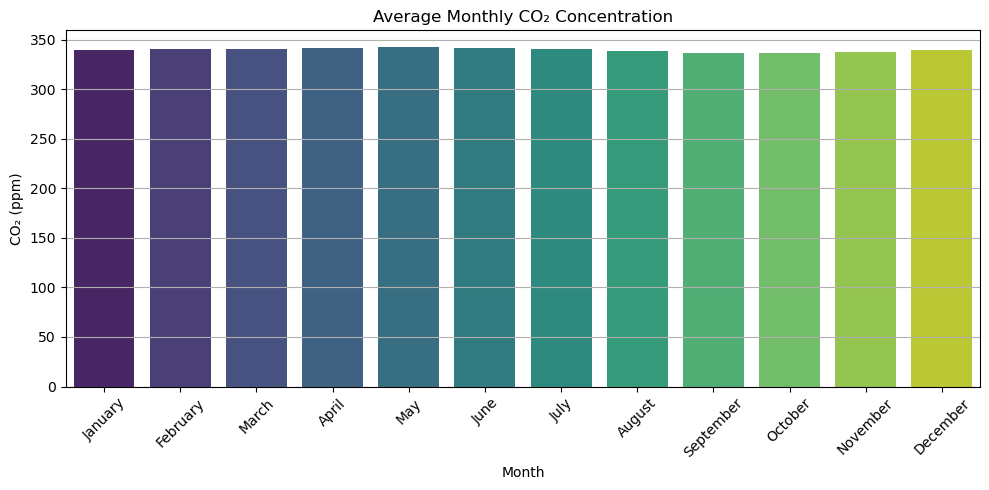

In [14]:
monthly_avg = data.copy()
monthly_avg['Month'] = monthly_avg.index.month_name()

# Group by month and calculate average CO2
monthly_mean = monthly_avg.groupby('Month')['co2'].mean()

# To keep months in calendar order
months_order = ['January', 'February', 'March', 'April', 'May', 'June',
                'July', 'August', 'September', 'October', 'November', 'December']

# Plot the barplot
plt.figure(figsize=(10, 5))
sns.barplot(x=monthly_mean.index, y=monthly_mean.values, order=months_order, palette='viridis')
plt.title('Average Monthly CO₂ Concentration')
plt.ylabel('CO₂ (ppm)')
plt.xlabel('Month')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


##### Barplot shows the monthly average Co2 concentration from 1965 to 2000


<Axes: xlabel='Month', ylabel='co2'>

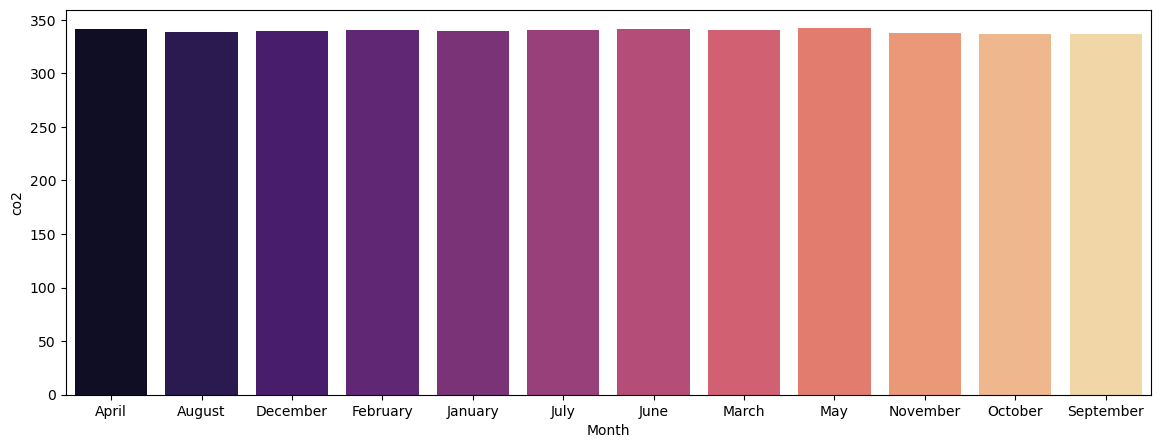

In [15]:
plt.figure(figsize=(14,5))
sns.barplot(monthly_mean,palette = 'magma')

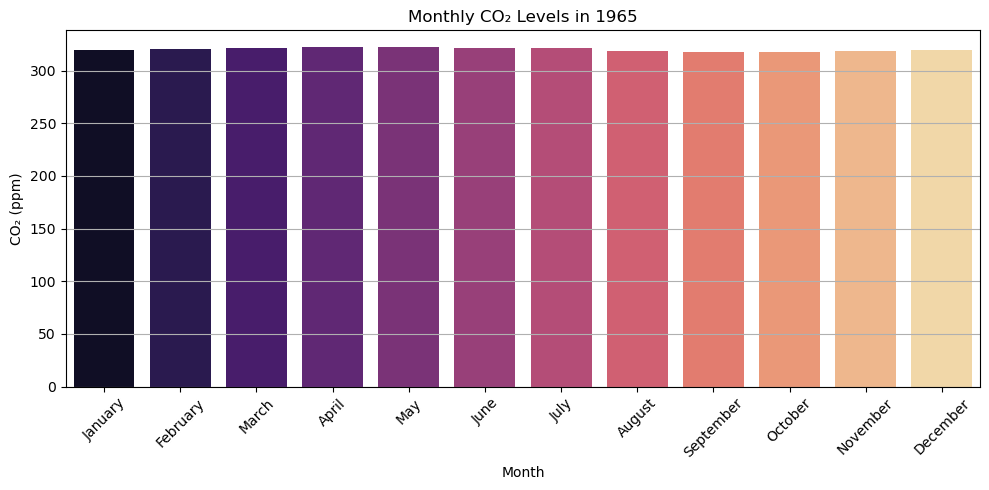

In [16]:


# Filter data for the year 1965
data_1965 = data.loc['1965']

# Barplot for 1965
plt.figure(figsize=(10, 5))
sns.barplot(x=data_1965.index.month_name(), y=data_1965['co2'], palette='magma')
plt.title('Monthly CO₂ Levels in 1965')
plt.xlabel('Month')
plt.ylabel('CO₂ (ppm)')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


##### Barplot shows the Monthly co2 level in 1965. 
##### As we see the values line in the range below 350 ppm. 

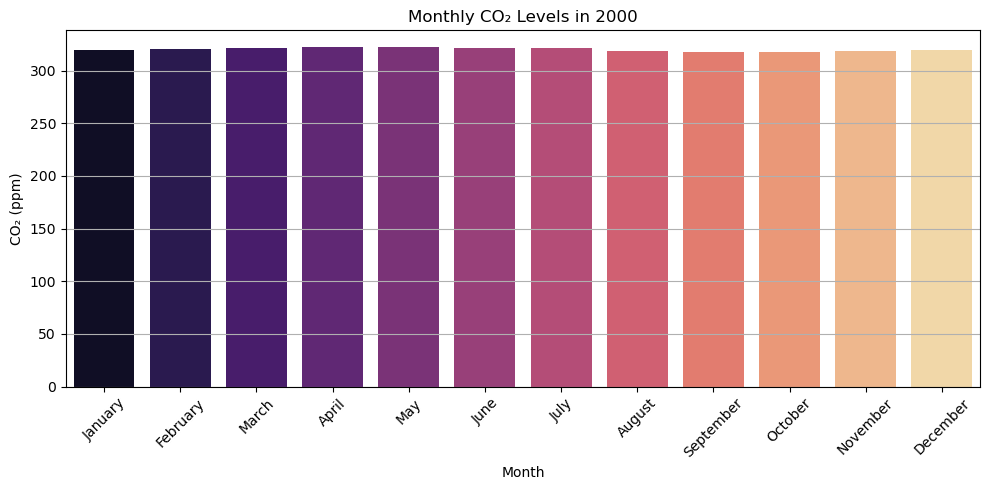

In [17]:
# Filter data for the year 1965
data_2000 = data.loc['2000']

# Barplot for 1965
plt.figure(figsize=(10, 5))
sns.barplot(x=data_1965.index.month_name(), y=data_1965['co2'], palette='magma')
plt.title('Monthly CO₂ Levels in 2000')
plt.xlabel('Month')
plt.ylabel('CO₂ (ppm)')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


##### Barplot shows the Monthly co2 level in 2000. 
##### As we see the values line in the range above 350 ppm. 

##### **Decompose the data into different components. Create a plot of the decomposition.**

##### The seasonal variation looked to be about the same magnitude across time, so an additive decomposition might be good.

In [18]:
decomposition_a = seasonal_decompose(data, model='additive')


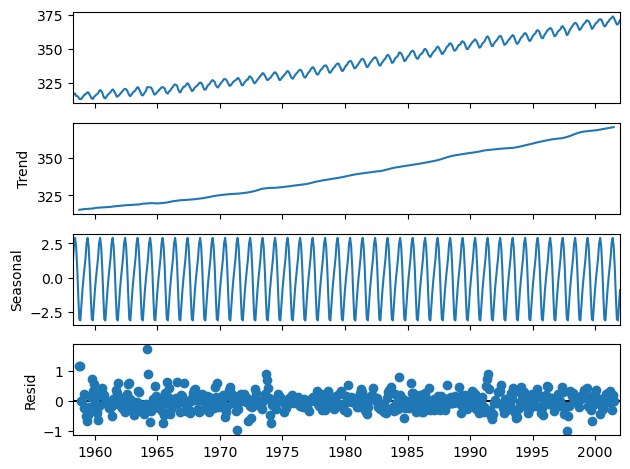

In [19]:
decomposition_a.plot()
plt.show()

In [20]:
decomposition_m = seasonal_decompose(data, model = "multiplicative")


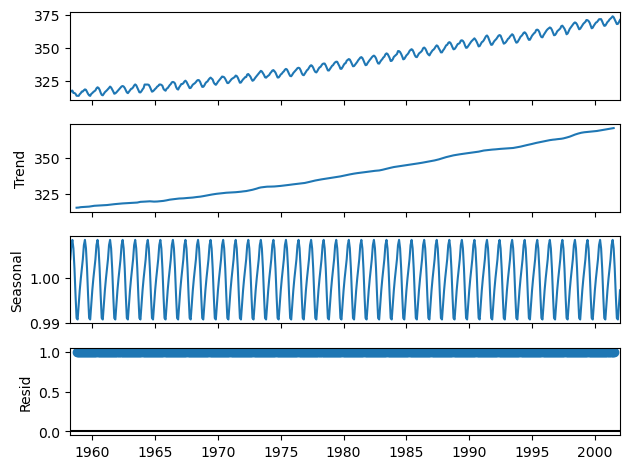

In [21]:
decomposition_m.plot()
plt.show()

##### from the graph seem above the resid is equal to 1 so we can say that multiplicative model in not good for this data

##### **Split the dataset such that the last 48 months are in the test set.**

In [22]:
train = data[:-48]
test = data[-48:]

In [23]:
train.head()

,co2
1958-03-31,316.100000
1958-04-30,317.200000
1958-05-31,317.433333
1958-06-30,315.625000
1958-07-31,315.625000


In [24]:
test.head()

,co2
1998-01-31,365.340
1998-02-28,366.200
1998-03-31,367.375
1998-04-30,368.525
1998-05-31,369.140


##### **Train the time series data using single, double and triple exponential smoothing model.**

##### Single Exponential Smoothing

##### smoothing_level denotes the smoothing parameter alpha which controls the weighting of recent observations in the forecast. A lower value (close to 0) means the model gives more weight to past observations, while a higher value (close to 1) focuses more on recent observations.

In [25]:
ses_model = ExponentialSmoothing(train, trend=None, seasonal=None).fit(smoothing_level=0.2)
ses_model_5 = ExponentialSmoothing(train, trend=None, seasonal=None).fit(smoothing_level=0.5)
ses_model_8 = ExponentialSmoothing(train, trend=None, seasonal=None).fit(smoothing_level=0.8)

In [73]:

fitted_forecast_se = ses_model.fittedfcast
new_data_se = train.copy()
#new_data['fitted_forecast'] = fitted_forecast

print(fitted_forecast_se)

[315.951197   315.9809576  316.22476608 316.46647953 316.29818362
 316.1635469  315.92083752 315.43667002 315.03433601 314.71246881
 314.70997505 314.86798004 315.23438403 315.53417389 315.96233911
 316.43487129 316.75289703 316.70731763 316.3458541  315.84168328
 315.35334662 315.2576773  315.31114184 315.52491347 315.81493078
 316.16694462 316.7575557  317.39104456 317.80283565 317.85426852
 317.43841481 316.78573185 316.19658548 315.96226838 316.00981471
 316.19285177 316.48428141 316.89242513 317.3979401  318.01335208
 318.36068167 318.35254533 318.03703627 317.43762901 317.02010321
 316.82608257 316.85686605 317.07049284 317.38139428 317.84111542
 318.38289234 318.88631387 319.2090511  319.25224088 318.94845937
 318.37210083 317.79268066 317.54414453 317.54031562 317.7772525
 318.01513533 318.38410827 318.96228661 319.58982929 319.96386343
 319.89109075 319.4328726  318.77629808 318.23103846 317.98483077
 318.05786462 318.32629169 319.06103335 319.64882668 320.11906135
 320.495249

In [74]:
new_data_se.head()

,co2
1958-03-31,316.100000
1958-04-30,317.200000
1958-05-31,317.433333
1958-06-30,315.625000
1958-07-31,315.625000


In [75]:

new_data_se.loc['1998-01-30 00:00:00'] = [np.nan] * len(new_data_se.columns)

print(new_data_se)

                            co2
1958-03-31 00:00:00  316.100000
1958-04-30 00:00:00  317.200000
1958-05-31 00:00:00  317.433333
1958-06-30 00:00:00  315.625000
1958-07-31 00:00:00  315.625000
...                         ...
1997-09-30 00:00:00  360.150000
1997-10-31 00:00:00  360.750000
1997-11-30 00:00:00  362.380000
1997-12-31 00:00:00  364.250000
1998-01-30 00:00:00         NaN

[479 rows x 1 columns]


In [29]:
new_data_se['fitted_forecast'] = fitted_forecast_se

In [30]:
new_data_se.isnull().sum()

co2                1
fitted_forecast    0
dtype: int64

In [31]:
new_data_se

,co2,fitted_forecast
1958-03-31 00:00:00,316.100000,315.951197
1958-04-30 00:00:00,317.200000,315.980958
1958-05-31 00:00:00,317.433333,316.224766
1958-06-30 00:00:00,315.625000,316.466480
1958-07-31 00:00:00,315.625000,316.298184
...,...,...
1997-09-30 00:00:00,360.150000,364.008143
1997-10-31 00:00:00,360.750000,363.236514
1997-11-30 00:00:00,362.380000,362.739211
1997-12-31 00:00:00,364.250000,362.667369


Text(0.5, 0, 'Simple Exponential Smoothing')

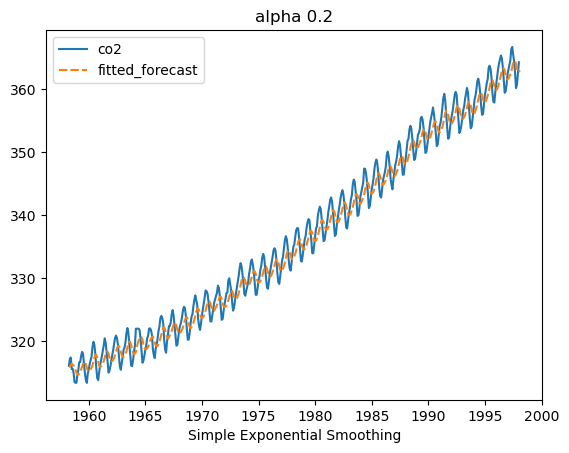

In [70]:
sns.lineplot(new_data_se)
plt.title("alpha 0.2")
plt.xlabel("Simple Exponential Smoothing")

##### the plots show the forecasted values vs actual values of Simple Exponential smoothing at alpha 0.2

Text(0.5, 1.0, 'alpha 0.5')

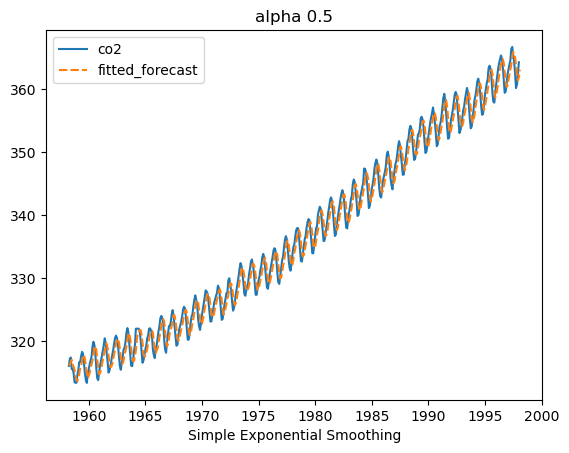

In [71]:
fitted_forecast_se_5 = ses_model_5.fittedfcast
new_data_se_5 = train.copy()
new_data_se_5.loc['1998-01-30 00:00:00'] = [np.nan] * len(new_data_se_5.columns)
new_data_se_5['fitted_forecast'] = fitted_forecast_se_5
sns.lineplot(new_data_se_5)
plt.xlabel("Simple Exponential Smoothing")
plt.title("alpha 0.5")


##### the plots show the forecasted values vs actual values of Simple Exponential smoothing at alpha 0.5

Text(0.5, 1.0, 'alpha 0.8')

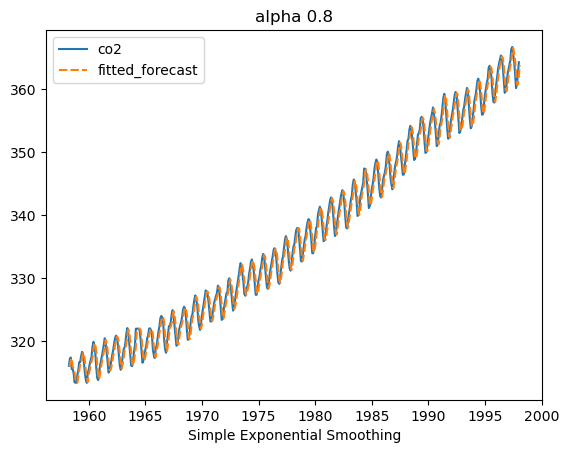

In [72]:
fitted_forecast_se_8 = ses_model_8.fittedfcast
new_data_se_8 = train.copy()
new_data_se_8.loc['1998-01-30 00:00:00'] = [np.nan] * len(new_data_se_8.columns)
new_data_se_8['fitted_forecast'] = fitted_forecast_se_8
sns.lineplot(new_data_se_8)
plt.xlabel("Simple Exponential Smoothing")
plt.title("alpha 0.8")

##### the plots show the forecasted values vs actual values of Simple Exponential smoothing at alpha 0.8

##### After the comparison between the three alpha values we know that in Simple Exponential smoothing for better forecast we have to take in  more alpha which is lean towards in recent data but gives less MSE and MAE and more accurate values. 

##### **Double Exponential Smoothing**

##### smoothing_level=0.2: The weight alpha given to recent observations when smoothing the level component.
##### smoothing_slope=0.2: The weight beta given to recent changes in the trend when updating the trend component.

In [86]:
des_model = ExponentialSmoothing(train, trend='add', seasonal=None).fit(smoothing_level=0.2, smoothing_slope=0.2)
des_model_5 = ExponentialSmoothing(train, trend='add', seasonal=None).fit(smoothing_level=0.5, smoothing_slope=0.5)
des_model_8 = ExponentialSmoothing(train, trend='add', seasonal=None).fit(smoothing_level=0.8, smoothing_slope=0.8)

In [87]:
fitted_forecast_de = des_model.fittedfcast
new_data_de = train.copy()
#new_data['fitted_forecast'] = fitted_forecast

print(fitted_forecast_de)

[315.65406047 315.65981241 315.94602146 316.28114785 316.16133638
 316.04403374 315.77143029 315.17249031 314.60843872 314.1098599
 313.98960244 314.11381238 314.55662783 315.00461509 315.65815362
 316.4176583  317.02955571 317.19889141 316.91740432 316.35351847
 315.69926905 315.43789875 315.36228657 315.51350535 315.81194017
 316.24121042 317.0087782  317.90048129 318.58082452 318.82626612
 318.44356875 317.64666811 316.78988087 316.27085585 316.08780159
 316.11984613 316.35168791 316.79909382 317.44085479 318.28662938
 318.87678387 319.04063611 318.77209246 318.06097384 317.44563999
 317.03754731 316.89477128 317.0107596  317.30811987 317.85188329
 318.5688187  319.30561428 319.86282617 320.07608263 319.8146445
 319.12224155 318.30409619 317.79441606 317.57089531 317.6782429
 317.86399125 318.27109695 318.99993763 319.87201267 320.5051922
 320.60352813 320.16205575 319.35839562 318.56313169 318.05439527
 317.92923033 318.09792917 318.90897107 319.68144574 320.39216766
 321.02505848 

In [88]:
new_data_de.head()

,co2
1958-03-31,316.100000
1958-04-30,317.200000
1958-05-31,317.433333
1958-06-30,315.625000
1958-07-31,315.625000


In [89]:
new_data_de.loc['1998-01-30 00:00:00'] = [np.nan] * len(new_data_de.columns)

new_data_de.head()

,co2
1958-03-31 00:00:00,316.100000
1958-04-30 00:00:00,317.200000
1958-05-31 00:00:00,317.433333
1958-06-30 00:00:00,315.625000
1958-07-31 00:00:00,315.625000


In [90]:
new_data_de['fitted_forecast'] = fitted_forecast_de

In [91]:
new_data_de.head()

,co2,fitted_forecast
1958-03-31 00:00:00,316.100000,315.654060
1958-04-30 00:00:00,317.200000,315.659812
1958-05-31 00:00:00,317.433333,315.946021
1958-06-30 00:00:00,315.625000,316.281148
1958-07-31 00:00:00,315.625000,316.161336


Text(0.5, 1.0, 'alpha 0.2 and beta 0.2')

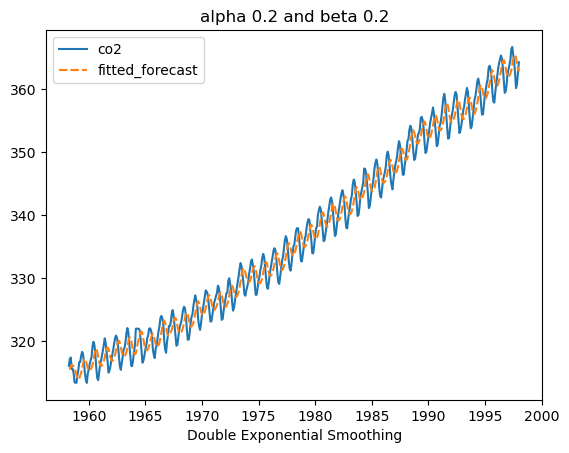

In [92]:
sns.lineplot(new_data_de)
plt.xlabel("Double Exponential Smoothing")
plt.title("alpha 0.2 and beta 0.2")

##### Graph show the forecast vs actual values of Double Exponential Smoothing at parameter 0.2

Text(0.5, 1.0, 'alpha 0.5 and beta 0.5')

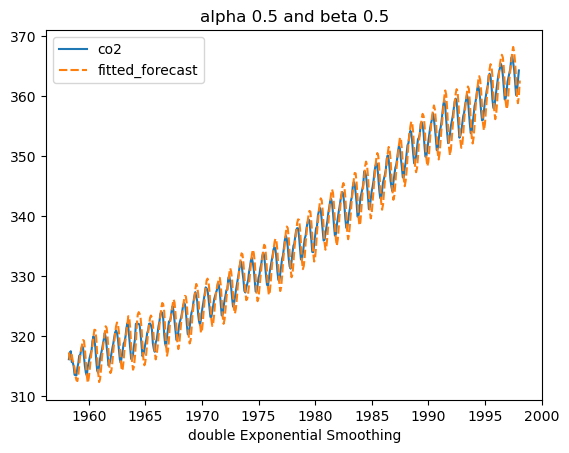

In [93]:
fitted_forecast_de_5 = des_model_5.fittedfcast
new_data_de_5 = train.copy()
new_data_de_5.loc['1998-01-30 00:00:00'] = [np.nan] * len(new_data_de_5.columns)
new_data_de_5['fitted_forecast'] = fitted_forecast_de_5
sns.lineplot(new_data_de_5)
plt.xlabel('double Exponential Smoothing')
plt.title("alpha 0.5 and beta 0.5")

##### Graph show the forecast vs actual values of Double Exponential Smoothing at parameter 0.5

Text(0.5, 1.0, 'alpha 0.8 and beta 0.8')

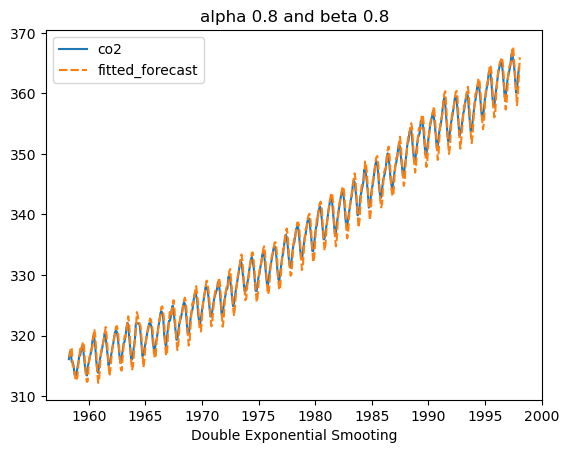

In [94]:
fitted_forecast_de_8 = des_model_8.fittedfcast
new_data_de_8 = train.copy()
new_data_de_8.loc['1998-01-30 00:00:00'] = [np.nan] * len(new_data_de_8.columns)
new_data_de_8['fitted_forecast'] = fitted_forecast_de_8
sns.lineplot(new_data_de_8)
plt.xlabel("Double Exponential Smooting")
plt.title("alpha 0.8 and beta 0.8")

##### Graph show the forecast vs actual values of Double Exponential Smoothing at parameter 0.8

##### After analysis of three parameter values we know that the double Exponential Smoothing is better for the we take parameter values average/medium that why at parameter = 0.5 it give more accurate forecast

##### **Triple Exponential Smoothing (Holt-Winters)**

##### smoothing_level=0.2: The weight alpha given to recent observations when smoothing the level component.
##### smoothing_slope=0.2: The weight beta given to recent changes in the trend when updating the trend component.
##### Smoothing_seasonal = 0.8: The weight Gamma given to recent change in the sesonality when updating the seasonal component.

In [98]:
tes_model = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=12).fit(
    smoothing_level=0.2, smoothing_slope=0.2, smoothing_seasonal=0.2)
tes_model_5 = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=12).fit(
    smoothing_level=0.5, smoothing_slope=0.5, smoothing_seasonal=0.5)
tes_model_8 = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=12).fit(
    smoothing_level=0.8, smoothing_slope=0.8, smoothing_seasonal=0.8)

In [99]:
fitted_forecast_te = tes_model.fittedfcast
new_data_te = train.copy()
#new_data['fitted_forecast'] = fitted_forecast

print(fitted_forecast_te)

[316.03345248 317.12232853 317.68990134 316.85503952 315.47636563
 313.89063267 312.72104474 312.82134067 313.95487522 314.96284458
 315.85915222 316.70942514 317.33890838 318.27217703 318.58753062
 317.50614185 316.77229806 315.29300369 313.72224279 313.57057564
 314.20992261 315.44545305 316.33983756 317.30475151 317.70295911
 318.70455481 319.30099127 318.60027885 317.83970166 316.50381454
 315.03064031 314.65988786 315.33779126 316.22281541 317.04692958
 317.85703769 318.27665044 319.43374498 319.94044477 319.21779464
 318.2059396  316.59284268 315.2467969  315.00921658 316.06335338
 317.12091761 317.95152175 318.81743936 319.38538272 320.5554961
 321.23001986 320.35591589 319.18921391 317.62535684 316.19499215
 316.09406913 316.85846091 317.79273934 318.57703399 319.40782082
 319.97663915 320.94123491 321.56903295 320.94671342 319.8717267
 318.160039   316.50132405 316.20124588 317.08363018 318.04231852
 319.01915469 319.7823248  321.05779663 322.47658008 323.101674
 322.20390905 

In [100]:
new_data_te.head()

,co2
1958-03-31,316.100000
1958-04-30,317.200000
1958-05-31,317.433333
1958-06-30,315.625000
1958-07-31,315.625000


In [101]:
new_data_te.loc['1998-01-30 00:00:00'] = [np.nan] * len(new_data_te.columns)

new_data_te.head()

,co2
1958-03-31 00:00:00,316.100000
1958-04-30 00:00:00,317.200000
1958-05-31 00:00:00,317.433333
1958-06-30 00:00:00,315.625000
1958-07-31 00:00:00,315.625000


In [102]:
new_data_te['fitted_forecast'] = fitted_forecast_te

In [103]:
new_data_te.head()

,co2,fitted_forecast
1958-03-31 00:00:00,316.100000,316.033452
1958-04-30 00:00:00,317.200000,317.122329
1958-05-31 00:00:00,317.433333,317.689901
1958-06-30 00:00:00,315.625000,316.855040
1958-07-31 00:00:00,315.625000,315.476366


Text(0.5, 1.0, 'Alpha 0.2, beta 0.2 and Gamma 0.2')

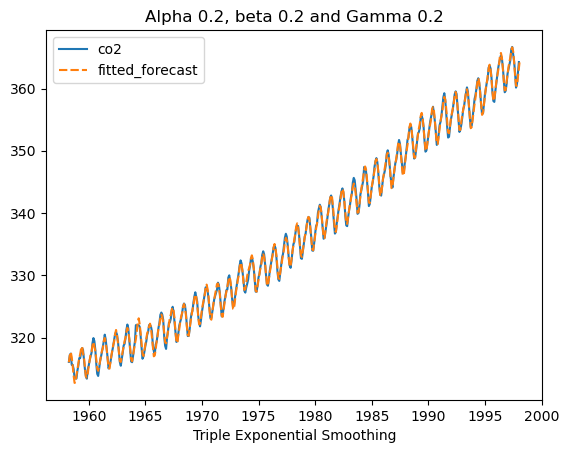

In [105]:
sns.lineplot(new_data_te)
plt.xlabel("Triple Exponential Smoothing")
plt.title("Alpha 0.2, beta 0.2 and Gamma 0.2")

##### The graph shows the Triple Exponential Smoothing actual vs forecast value at the parameter 0.2

Text(0.5, 1.0, 'alpha 0.5, beta 0.5 and Gamma 0.5')

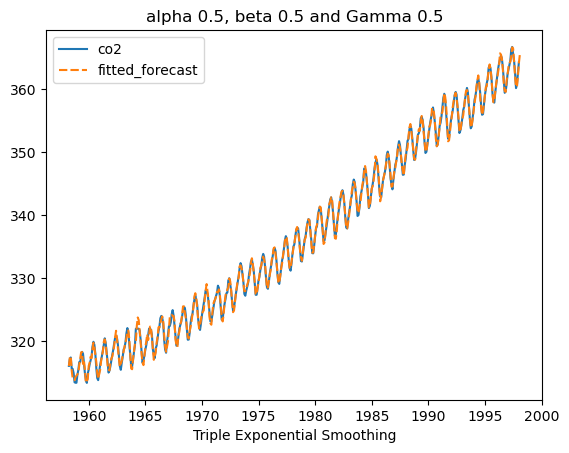

In [106]:
fitted_forecast_te_5 = tes_model_5.fittedfcast
new_data_te_5 = train.copy()
new_data_te_5.loc['1998-01-30 00:00:00'] = [np.nan] * len(new_data_te_5.columns)
new_data_te_5['fitted_forecast'] = fitted_forecast_te_5
sns.lineplot(new_data_te_5)
plt.xlabel("Triple Exponential Smoothing")
plt.title("alpha 0.5, beta 0.5 and Gamma 0.5")

##### The graph shows the Triple Exponential Smoothing actual vs forecast value at the parameter 0.5

Text(0.5, 1.0, 'alpha 0.8, beta 0.8 and Gamma 0.8')

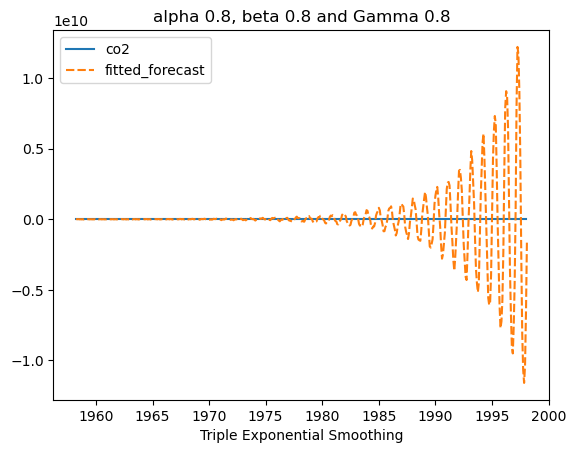

In [107]:
fitted_forecast_te_8 = tes_model_8.fittedfcast
new_data_te_8 = train.copy()
new_data_te_8.loc['1998-01-30 00:00:00'] = [np.nan] * len(new_data_te_8.columns)
new_data_te_8['fitted_forecast'] = fitted_forecast_te_8
sns.lineplot(new_data_te_8)
plt.xlabel("Triple Exponential Smoothing")
plt.title("alpha 0.8, beta 0.8 and Gamma 0.8")

##### The graph shows the Triple Exponential Smoothing actual vs forecast value at the parameter 0.8

##### After analysis of 3three parameter we can say that the best optimal parameter for the triple exponential smoothing is 0.2 

##### **Using the trained model, forecast the next 48 time step values for each case (single,**
##### **double and triple ES) using different combinations of the smoothing parameters.**

##### **single ES**

In [51]:
ses_forecast_48 = ses_model.forecast(steps = 48)
ses_forecast_48

1998-01-31    362.983895
1998-02-28    362.983895
1998-03-31    362.983895
1998-04-30    362.983895
1998-05-31    362.983895
1998-06-30    362.983895
1998-07-31    362.983895
1998-08-31    362.983895
1998-09-30    362.983895
1998-10-31    362.983895
1998-11-30    362.983895
1998-12-31    362.983895
1999-01-31    362.983895
1999-02-28    362.983895
1999-03-31    362.983895
1999-04-30    362.983895
1999-05-31    362.983895
1999-06-30    362.983895
1999-07-31    362.983895
1999-08-31    362.983895
1999-09-30    362.983895
1999-10-31    362.983895
1999-11-30    362.983895
1999-12-31    362.983895
2000-01-31    362.983895
2000-02-29    362.983895
2000-03-31    362.983895
2000-04-30    362.983895
2000-05-31    362.983895
2000-06-30    362.983895
2000-07-31    362.983895
2000-08-31    362.983895
2000-09-30    362.983895
2000-10-31    362.983895
2000-11-30    362.983895
2000-12-31    362.983895
2001-01-31    362.983895
2001-02-28    362.983895
2001-03-31    362.983895
2001-04-30    362.983895


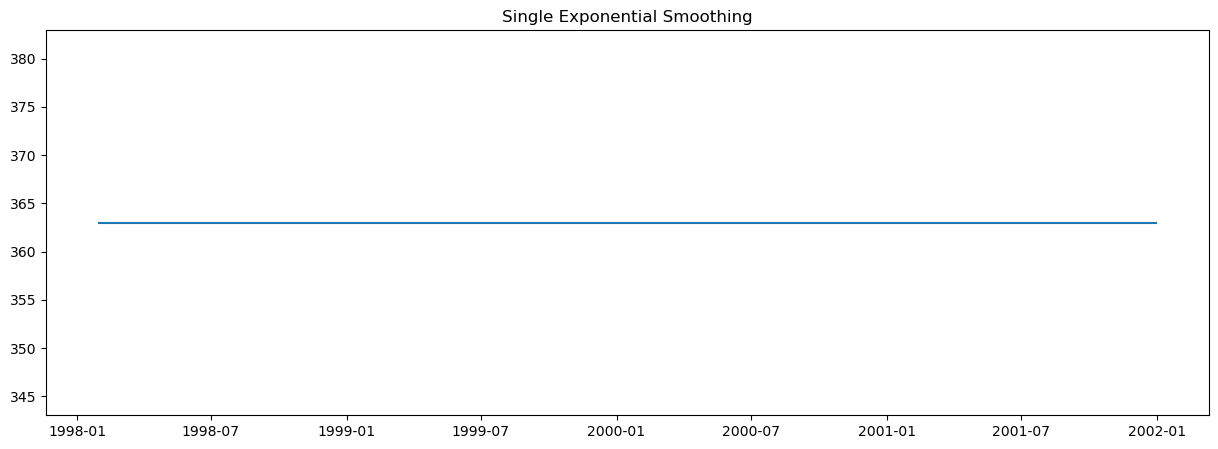

In [52]:
plt.figure(figsize=(15,5))
sns.lineplot(ses_forecast_48)
plt.title("Single Exponential Smoothing")
plt.show()

##### The graph show the trend of the SE forecast values

##### **Double ES**

In [53]:
des_forecast_48 = des_model.forecast(steps = 48)
des_forecast_48 

1998-01-31    363.079468
1998-02-28    362.975480
1998-03-31    362.871492
1998-04-30    362.767504
1998-05-31    362.663516
1998-06-30    362.559528
1998-07-31    362.455540
1998-08-31    362.351552
1998-09-30    362.247564
1998-10-31    362.143576
1998-11-30    362.039588
1998-12-31    361.935600
1999-01-31    361.831612
1999-02-28    361.727624
1999-03-31    361.623636
1999-04-30    361.519648
1999-05-31    361.415660
1999-06-30    361.311672
1999-07-31    361.207684
1999-08-31    361.103696
1999-09-30    360.999708
1999-10-31    360.895720
1999-11-30    360.791732
1999-12-31    360.687744
2000-01-31    360.583756
2000-02-29    360.479768
2000-03-31    360.375780
2000-04-30    360.271792
2000-05-31    360.167804
2000-06-30    360.063816
2000-07-31    359.959828
2000-08-31    359.855840
2000-09-30    359.751852
2000-10-31    359.647864
2000-11-30    359.543876
2000-12-31    359.439888
2001-01-31    359.335900
2001-02-28    359.231912
2001-03-31    359.127924
2001-04-30    359.023936


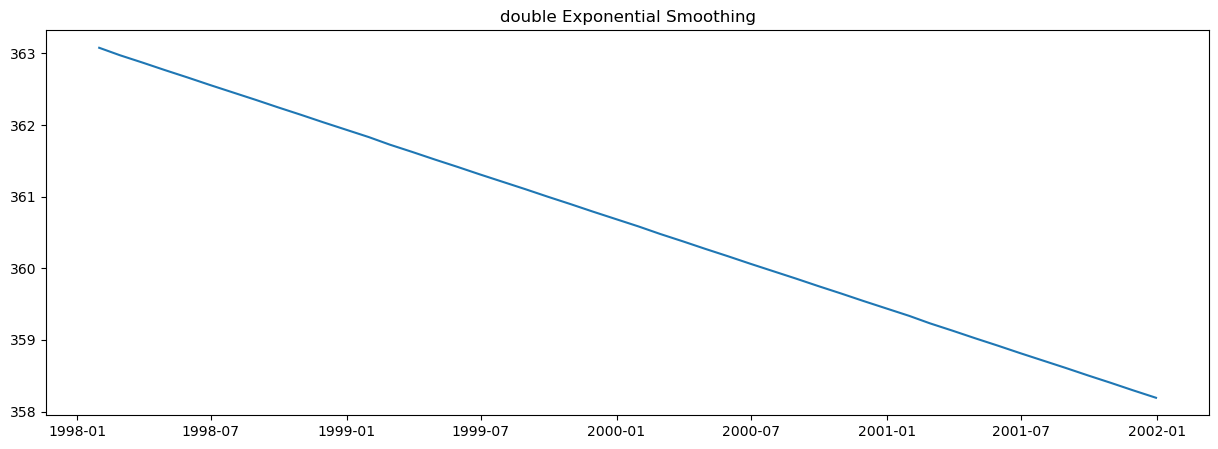

In [54]:
plt.figure(figsize=(15,5))
sns.lineplot(des_forecast_48)
plt.title("double Exponential Smoothing")
plt.show()

##### The graph show the trend of the DE forecast values

##### **Triple ES**

In [55]:
tes_forecast_48 = tes_model.forecast(steps=48)
tes_forecast_48

1998-01-31    364.589642
1998-02-28    365.434599
1998-03-31    366.351799
1998-04-30    367.695252
1998-05-31    368.223699
1998-06-30    367.529373
1998-07-31    366.060566
1998-08-31    363.989418
1998-09-30    362.224679
1998-10-31    362.500557
1998-11-30    363.913998
1998-12-31    365.220661
1999-01-31    366.308017
1999-02-28    367.152974
1999-03-31    368.070175
1999-04-30    369.413628
1999-05-31    369.942074
1999-06-30    369.247748
1999-07-31    367.778942
1999-08-31    365.707793
1999-09-30    363.943055
1999-10-31    364.218932
1999-11-30    365.632374
1999-12-31    366.939037
2000-01-31    368.026393
2000-02-29    368.871350
2000-03-31    369.788550
2000-04-30    371.132004
2000-05-31    371.660450
2000-06-30    370.966124
2000-07-31    369.497317
2000-08-31    367.426169
2000-09-30    365.661431
2000-10-31    365.937308
2000-11-30    367.350750
2000-12-31    368.657413
2001-01-31    369.744769
2001-02-28    370.589726
2001-03-31    371.506926
2001-04-30    372.850379


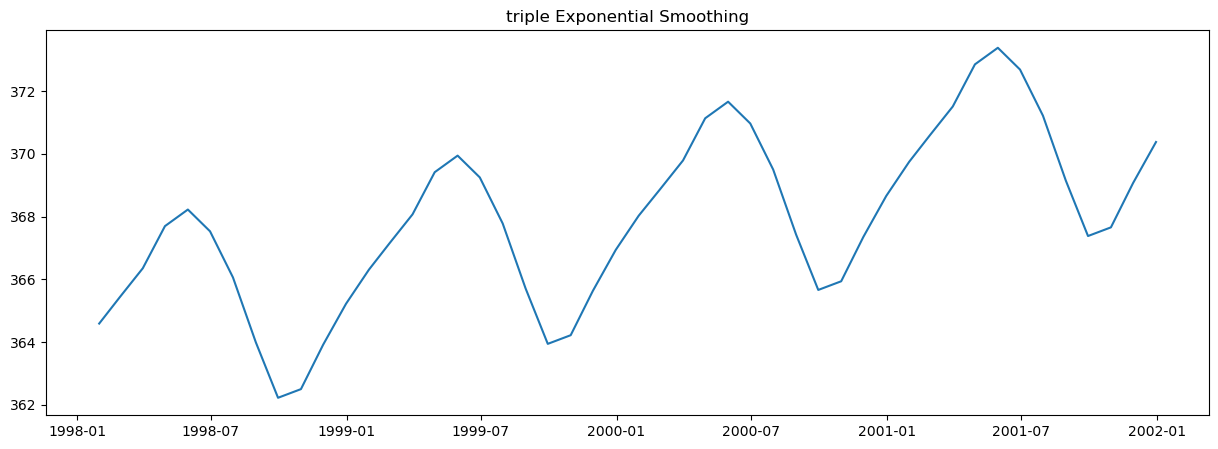

In [56]:
plt.figure(figsize=(15,5))
sns.lineplot(tes_forecast_48)
plt.title("triple Exponential Smoothing")
plt.show()

##### The graph show the trend of the SE forecast values because triple exponential smoothinng takes trend and seasonality. it capture the data more well and show forecast value graph same as actual value graph.

##### **Calculate the MAE and MSE between the actual test data and the forecasts obtained to**
##### **determine the optimal values of the smoothing parameters.**

In [57]:
def evaluate_model(model, test):
    forecast = model.forecast(48)
    mae = mean_absolute_error(test, forecast)
    mse = mean_squared_error(test, forecast)
    return mae, mse, forecast

In [58]:
ses_mae, ses_mse, ses_forecast = evaluate_model(ses_model, test)
print(f"Single ES (alpha - 0.2) - MAE: {ses_mae:.2f}, MSE: {ses_mse:.2f}")
ses_mae_5, ses_mse_5, ses_forecast_5 = evaluate_model(ses_model_5, test)
print(f"Single ES (alpha - 0.5) - MAE: {ses_mae_5:.2f}, MSE: {ses_mse_5:.2f}")
ses_mae_8, ses_mse_8, ses_forecast_8 = evaluate_model(ses_model_8, test)
print(f"Single ES (alpha - 0.8) - MAE: {ses_mae_8:.2f}, MSE: {ses_mse_8:.2f}")
print("--------------------------------------------------")
des_mae, des_mse, des_forecast = evaluate_model(des_model, test)
print(f"Double ES (alpha - 0.2, beta - 0.2) - MAE: {des_mae:.2f}, MSE: {des_mse:.2f}")
des_mae_5, des_mse_5, des_forecast_5 = evaluate_model(des_model_5, test)
print(f"Double ES (alpha - 0.5, beta - 0.5) - MAE: {des_mae_5:.2f}, MSE: {des_mse_5:.2f}")
des_mae_8, des_mse_8, des_forecast_8 = evaluate_model(des_model_8, test)
print(f"Double ES (alpha - 0.8, beta - 0.8) - MAE: {des_mae_8:.2f}, MSE: {des_mse_8:.2f}")
print("----------------------------------------------------")
tes_mae, tes_mse, tes_forecast = evaluate_model(tes_model, test)
print(f"Triple ES (alpha - 0.2, beta - 0.2, gamma - 0.2) - MAE: {tes_mae:.2f}, MSE: {tes_mse:.2f}")
tes_mae_5, tes_mse_5, tes_forecast_5 = evaluate_model(tes_model_5, test)
print(f"Triple ES (alpha - 0.5, beta - 0.5, gamma - 0.5) - MAE: {tes_mae_5:.2f}, MSE: {tes_mse_5:.2f}")
tes_mae_8, tes_mse_8, tes_forecast_8 = evaluate_model(tes_model_8, test)
print(f"Triple ES (alpha - 0.8, beta - 0.8, gamma - 0.8) - MAE: {tes_mae_8:.2f}, MSE: {tes_mse_8:.2f}")

Single ES (alpha - 0.2) - MAE: 5.78, MSE: 39.07
Single ES (alpha - 0.5) - MAE: 5.71, MSE: 38.23
Single ES (alpha - 0.8) - MAE: 4.95, MSE: 30.20
--------------------------------------------------
Double ES (alpha - 0.2, beta - 0.2) - MAE: 8.13, MSE: 77.50
Double ES (alpha - 0.5, beta - 0.5) - MAE: 5.75, MSE: 50.21
Double ES (alpha - 0.8, beta - 0.8) - MAE: 43.59, MSE: 2582.86
----------------------------------------------------
Triple ES (alpha - 0.2, beta - 0.2, gamma - 0.2) - MAE: 0.88, MSE: 1.01
Triple ES (alpha - 0.5, beta - 0.5, gamma - 0.5) - MAE: 4.66, MSE: 31.64
Triple ES (alpha - 0.8, beta - 0.8, gamma - 0.8) - MAE: 403908789725.65, MSE: 216244521446353733156864.00


##### After observing the values of MSE and MAE of each model we can say that at parameter 0.2 = Triples ES is the best model 

##### After observing the values of MSE and MAE of each model we can say that at parameter 0.5 = again Triple ES is the best model 

##### After observing the values of MSE and MAE of each model we can say that at parameter 0.8 = Single ES is the best model the values of MSE and MAE is total changed and we are getting very high MSE and MAE for the Tiple ES.

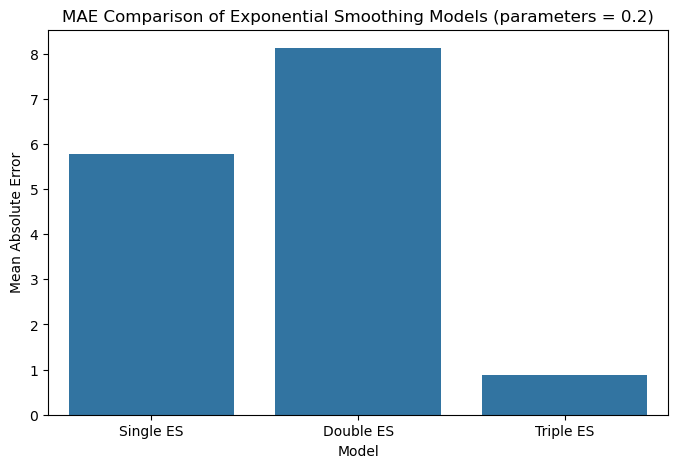

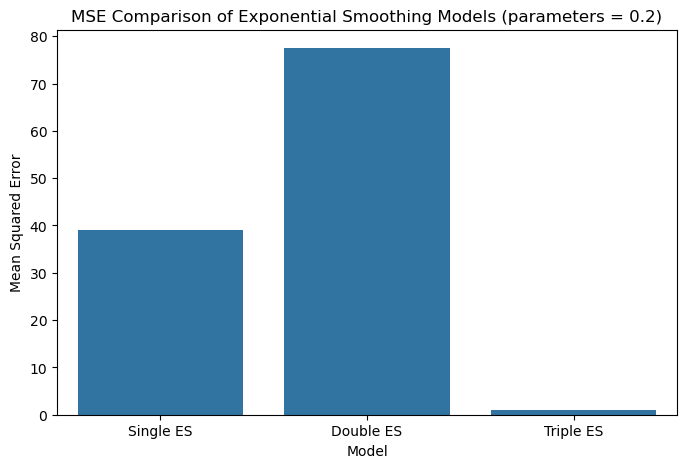

In [59]:

# Example data
data_2 = pd.DataFrame({
    'Model': ['Single ES', 'Double ES', 'Triple ES'],
    'MAE': [ses_mae, des_mae, tes_mae],
    'MSE': [ses_mse, des_mse, tes_mse]
})

# Plot MAE
plt.figure(figsize=(8, 5))
sns.barplot(x='Model', y='MAE', data=data_2)
plt.title('MAE Comparison of Exponential Smoothing Models (parameters = 0.2)')
plt.ylabel('Mean Absolute Error')
plt.show()

# Plot MSE
plt.figure(figsize=(8, 5))
sns.barplot(x='Model', y='MSE', data=data_2)
plt.title('MSE Comparison of Exponential Smoothing Models (parameters = 0.2)')
plt.ylabel('Mean Squared Error')
plt.show()


##### Bar plots shows the MSE and MAE of different models at parameter 0.2 were we can clearly observe that Triple ES model in good for the data

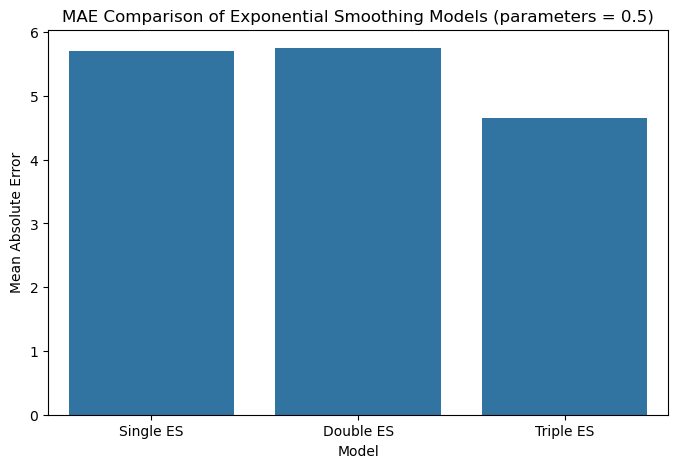

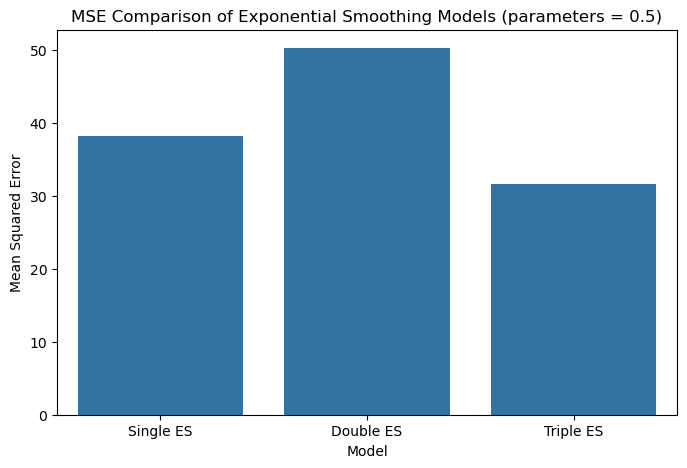

In [60]:

# Example data
data_5 = pd.DataFrame({
    'Model': ['Single ES', 'Double ES', 'Triple ES'],
    'MAE': [ses_mae_5, des_mae_5, tes_mae_5],
    'MSE': [ses_mse_5, des_mse_5, tes_mse_5]
})

# Plot MAE
plt.figure(figsize=(8, 5))
sns.barplot(x='Model', y='MAE', data=data_5)
plt.title('MAE Comparison of Exponential Smoothing Models (parameters = 0.5)')
plt.ylabel('Mean Absolute Error')
plt.show()

# Plot MSE
plt.figure(figsize=(8, 5))
sns.barplot(x='Model', y='MSE', data=data_5)
plt.title('MSE Comparison of Exponential Smoothing Models (parameters = 0.5)')
plt.ylabel('Mean Squared Error')
plt.show()


##### Bar plots shows the MSE and MAE of different models at parameter 0.5 were we can clearly observe that Triple ES model in good for the data

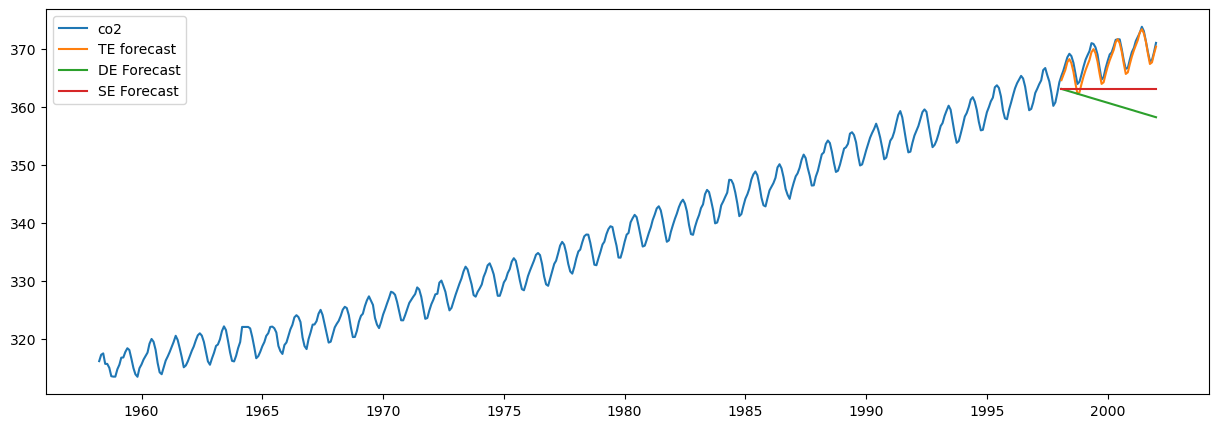

In [67]:
plt.figure(figsize=(15,5))
sns.lineplot(data)
sns.lineplot(tes_forecast_48,label = "TE forecast")
sns.lineplot(des_forecast_48, label = "DE Forecast")
sns.lineplot(ses_forecast_48, label = "SE Forecast")
# label = ('original','SE forecast, DE forecast, TE forecast')
# plt.legend(label)
plt.show()

##### the line plot show that forecast of different model at the parameter 0.2 from that we recognise that the Triple ES model gives the best forecast.

##### **Lastly, conclude which of the three models seems to be the most appropriate for our**
##### **data based on MAE and MSE errors and use the best model found to forecast the next 6**
##### **values**

In [110]:
best_model = min([(ses_mae + ses_mse, ses_model),
                  (des_mae + des_mse, des_model),
                  (tes_mae + tes_mse, tes_model)], key=lambda x: x[0])[1]

In [111]:
best_model

In [114]:
models_info = [
    ('Single ES', ses_mae + ses_mse, ses_model),
    ('Double ES', des_mae + des_mse, des_model),
    ('Triple ES', tes_mae + tes_mse, tes_model)
]

# Find the best model by total error (MAE + MSE)
best_model_name, best_error, best_model = min(models_info, key=lambda x: x[1])

print(f"The best model is: {best_model_name}, The error is {best_error}")


The best model is: Triple ES, The error is 1.8903033329664063


##### So from here we can conclude that Triple Exponential smoothing is best model with an combine error of MSE and MAE is 1.9

##### **Forecast value of Next 6 months using the Triple ES model**

In [116]:
best_model.forecast(steps=6)

1998-01-31    364.589642
1998-02-28    365.434599
1998-03-31    366.351799
1998-04-30    367.695252
1998-05-31    368.223699
1998-06-30    367.529373
Freq: ME, dtype: float64